# Required Things;

In [1]:
import os
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3cac0ed3-9b85-8885-04a1-df69568c066f)


# Required Libarries;

In [2]:
import numpy as np
import typing
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Data Collection & Pre-Processing;**

Data description;a real-world traffic speed dataset named PeMSD7. PeMSD7 was collected from Caltrans Performance Measurement System (PeMS) in real-time by over 39, 000 sensor stations, deployed across the major metropolitan areas of California state highway system. The dataset is also aggregated into 5-minute interval from 30-second data samples. We randomly select a medium and a large scale among the District 7 of California containing 228 and 1, 026 stations, labeled as PeMSD7(M) and PeMSD7(L), respectively, as data sources. The time range of PeMSD7 dataset is in the weekdays of May and June of 2012. Dataset PeMSD7(M/L) is now available under dataset folder.

In [4]:
!git clone "https://github.com/VeritasYin/STGCN_IJCAI-18"

Cloning into 'STGCN_IJCAI-18'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 77 (delta 17), reused 19 (delta 13), pack-reused 36
Unpacking objects: 100% (77/77), 34.94 MiB | 8.77 MiB/s, done.


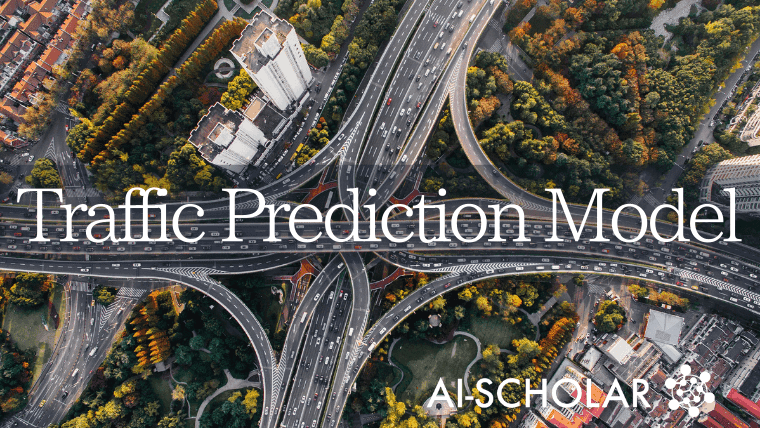

In [5]:
!unzip STGCN_IJCAI-18/dataset/PeMSD7_Full.zip

Archive:  STGCN_IJCAI-18/dataset/PeMSD7_Full.zip
  inflating: PeMSD7_V_228.csv        
  inflating: PeMSD7_V_1026.csv       
  inflating: PeMSD7_W_228.csv        
  inflating: PeMSD7_W_1026.csv       


In [6]:
route_distances = pd.read_csv(("/kaggle/working/PeMSD7_W_1026.csv"), header=None).to_numpy()

In [7]:
print(f"route_distances shape={route_distances.shape}")

route_distances shape=(1026, 1026)


In [8]:
speeds_array = pd.read_csv(("/kaggle/working/PeMSD7_V_1026.csv"), header=None).to_numpy()

In [9]:
print(f"speeds_array shape={speeds_array.shape}")

speeds_array shape=(12672, 1026)


**Sub-sampling roads;**
To reduce the problem size and make the training faster, we will only work with a sample of 26 roads out of the 228 roads in the dataset. We have chosen the roads by starting from road 0, choosing the 5 closest roads to it, and continuing this process until we get 25 roads. You can choose any other subset of the roads. We chose the roads in this way to increase the likelihood of having roads with correlated speed timeseries. sample_routes contains the IDs of the selected roads.

In [10]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]

In [11]:
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

In [12]:
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


**Data visualization And EDA;**

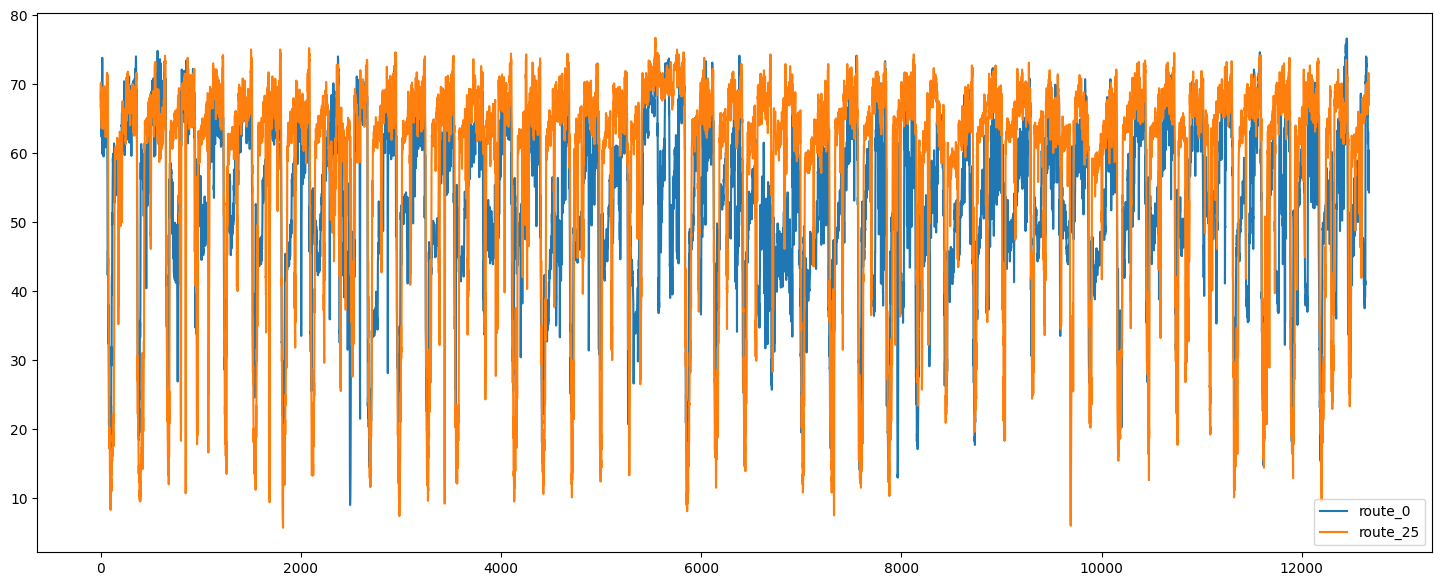

In [13]:
plt.figure(figsize=(18, 7))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

We can also visualize the correlation between the timeseries in different routes.



Text(0, 0.5, 'road number')

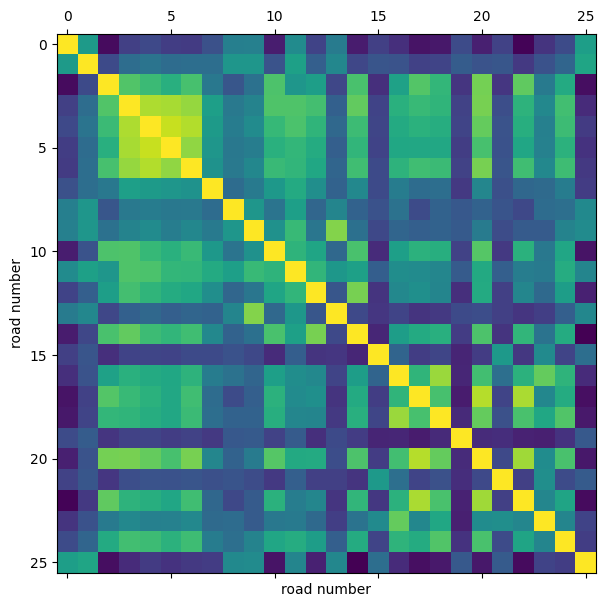

In [14]:
plt.figure(figsize=(9, 7))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

Split and normalize data;

In [15]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

In [16]:
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

In [17]:
print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


**Creating TensorFlow Datasets**;

Next, we create the datasets for our forecasting problem. The forecasting problem can be stated as follows: given a sequence of the road speed values at times t+1, t+2, ..., t+T, we want to predict the future values of the roads speed for times t+T+1, ..., t+T+h. So for each time t the inputs to our model are T vectors each of size N and the targets are h vectors each of size N, where N is the number of roads.

We use the Keras built-in function timeseries_dataset_from_array(). The function create_tf_dataset() below takes as input a numpy.ndarray and returns a tf.data.Dataset. In this function input_sequence_length=T and forecast_horizon=h.

The argument multi_horizon needs more explanation. Assume forecast_horizon=3. If multi_horizon=True then the model will make a forecast for time steps t+T+1, t+T+2, t+T+3. So the target will have shape (T,3). But if multi_horizon=False, the model will make a forecast only for time step t+T+3 and so the target will have shape (T, 1).

You may notice that the input tensor in each batch has shape (batch_size, input_sequence_length, num_routes, 1). The last dimension is added to make the model more general: at each time step, the input features for each raod may contain multiple timeseries. For instance, one might want to use temperature timeseries in addition to historical values of the speed as input features. In this example, however, the last dimension of the input is always 1.

We use the last 12 values of the speed in each road to forecast the speed for 3 time steps ahead:

In [18]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

In [19]:
def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

In [20]:
train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

Roads Graph Neural Network;

As mentioned before, we assume that the road segments form a graph. The PeMSD7 dataset has the road segments distance. The next step is to create the graph adjacency matrix from these distances.

In [21]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

The function compute_adjacency_matrix() returns a boolean adjacency matrix where 1 means there is an edge between two nodes. We use the following class to store the information about the graph

In [22]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 52


**Graph convolution layer And Network architecture;**

Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation in this Keras example. Note that in that example input to the layer is a 2D tensor of shape (num_nodes,in_feat) but in our example the input to the layer is a 4D tensor of shape (num_nodes, batch_size, input_seq_length, in_feat). The graph convolution layer performs the following steps:

->The nodes' representations are computed in self.compute_nodes_representation() by multiplying the input features by self.weight

->The aggregated neighbors' messages are computed in self.compute_aggregated_messages() by first aggregating the neighbors' representations and then multiplying the results by self.weight

->The final output of the layer is computed in self.update() by combining the nodes representations and the neighbors' aggregated messages

In [23]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

In [24]:
    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

LSTM plus graph convolution

By applying the graph convolution layer to the input tensor, we get another tensor containing the nodes' representations over time (another 4D tensor). For each time step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors but also we need to process the information over time. To this end, we can pass each node's tensor through a recurrent layer. The LSTMGC layer below, first applies a graph convolution layer to the inputs and then passes the results through a LSTM layer.

In [25]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


**Graph Neural Network Model Training;**

In [26]:
in_feat = 1
batch_size = 64
epochs = 50
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 26, 1)]       0         
                                                                 
 lstmgc (LSTMGC)             (None, 3, 26)             17101     
                                                                 
Total params: 17,101
Trainable params: 17,101
Non-trainable params: 0
_________________________________________________________________


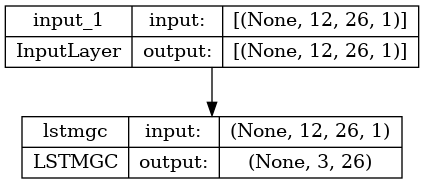

In [28]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [29]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/50
99/99 [==============================] - 8s 32ms/step - loss: 0.7412 - val_loss: 0.6816
Epoch 2/50
99/99 [==============================] - 2s 25ms/step - loss: 0.4272 - val_loss: 0.3805
Epoch 3/50
99/99 [==============================] - 2s 25ms/step - loss: 0.2902 - val_loss: 0.2839
Epoch 4/50
99/99 [==============================] - 2s 24ms/step - loss: 0.2398 - val_loss: 0.2486
Epoch 5/50
99/99 [==============================] - 3s 33ms/step - loss: 0.2141 - val_loss: 0.2227
Epoch 6/50
99/99 [==============================] - 2s 24ms/step - loss: 0.1941 - val_loss: 0.2014
Epoch 7/50
99/99 [==============================] - 2s 25ms/step - loss: 0.1771 - val_loss: 0.1833
Epoch 8/50
99/99 [==============================] - 2s 23ms/step - loss: 0.1622 - val_loss: 0.1728
Epoch 9/50
99/99 [==============================] - 2s 24ms/step - loss: 0.1538 - val_loss: 0.1670
Epoch 10/50
99/99 [==============================] - 3s 26ms/step - loss: 0.1494 - val_loss: 0.1632
Epoch 11/

**Making forecasts on test set;**

119/119 [==============================] - 1s 3ms/step
naive MAE: 0.21611326173223633, model MAE: 0.2054915212090784


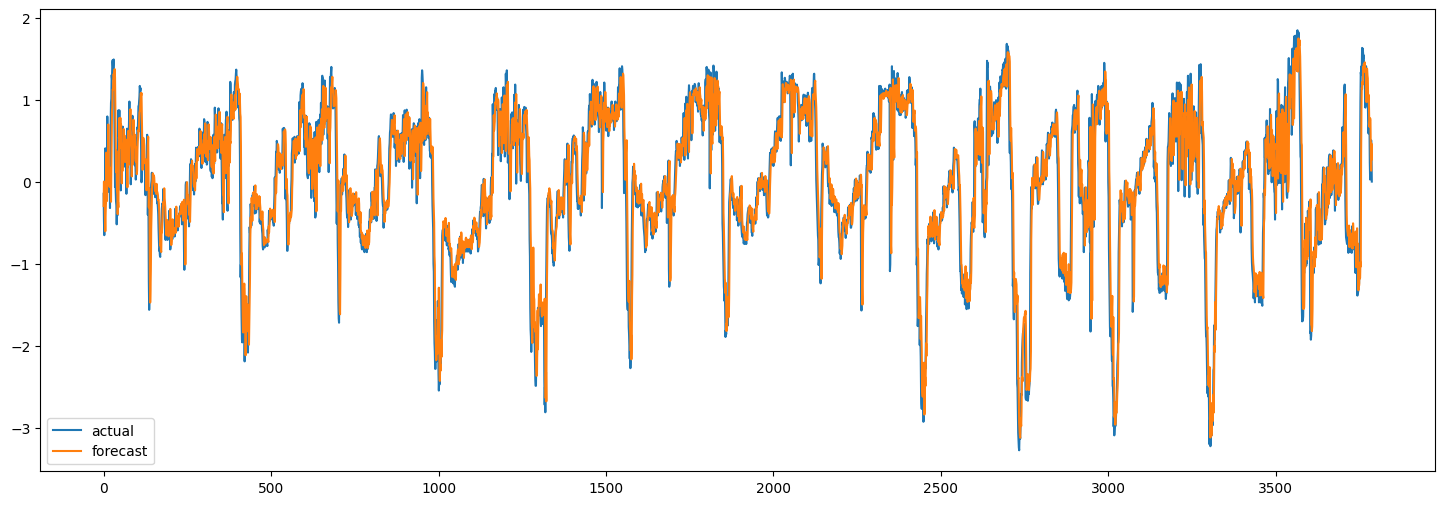

In [30]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

Relevant Article; https://www.ijcai.org/proceedings/2018/0505

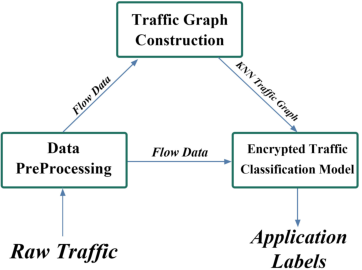

In [31]:
#